# IAU - Project

**Authors:** Peter Mačinec, Lukáš Janík

## Setup and import libraries

In [69]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

# models
from sklearn.linear_model import LinearRegression
from sklearn import model_selection as ms
from sklearn import metrics
from functools import reduce

## Read the data

Data are divided into two files, personal and other, so we need to read both of them:

In [70]:
# read datasets
df1 = pd.read_csv('data/personal_train.csv', index_col=0)
df2 = pd.read_csv('data/other_train.csv', index_col=0)

## Preprocessing

### Merge datasets

At first, we need to merge both datasets into one. In previous analysis, we found that name and address would be used for merging:

In [71]:
df_train = pd.merge(df1, df2, on=["name", "address"])

In descriptive analysis, we found some duplicates. In second dataset with medical information, there were some duplicates, so we will merge their values and drop duplicated rows.

### Data repairing

We know from a previous analysis that some data need to be repaired. Some columns have one value represented by more strings, another case is that column holds several values that need to be expanded, etc. In this section, data will be repaired at first so missing values would be replaced in next step.

All operations will be done using **Pipelines**, so whole preprocessing process will be reusable.

#### Merge and drop duplicates

As mentioned before, there are some duplicates. Let's check them:

In [72]:
duplicates = df_train[df_train.duplicated(['name', 'address'], keep='first')].sort_values('name')

In [73]:
duplicates.head()

,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,TT4,...,personal_info,T3 measured,on antithyroid medication,referral source,education-num,psych,occupation,TBG measured,TBG,pregnant
1656,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,f,t,t,f,82.0,...,NaN,f,f,other,13.0,f,Prof-specialty,f,?,f
855,Amelia Rodriguez,"087 Gary Port\r\nWest Sarah, KY 66896",77.0,F,1941-03-17,f,NaN,t,f,84.0,...,White|United-States\r\nBachelors -- Widowed|Un...,t,f,SVI,NaN,f,Sales,f,?,f
904,Angela Boyer,"3750 Chen Groves\r\nPamelatown, ME 02894",75.0,F,1942-12-28,NaN,NaN,t,f,92.0,...,White|United-States\r\nHS-grad -- Divorced|Own...,t,f,SVI,9.0,f,Priv-house-serv,f,?,f
1597,Anna Garcia,"71052 Annette Roads\r\nChristinechester, MT 16249",65.0,F,1953-05-06,f,f,f,f,NaN,...,White|United-States\r\nHS-grad -- Never-marrie...,f,f,NaN,9.0,f,Handlers-cleaners,f,?,NaN
2204,Annette Hunt,USNV Lamb\r\nFPO AA 85130,33.0,F,1984-12-08,f,f,f,f,NaN,...,White|United-States\r\nSome-college -- Married...,f,f,NaN,10.0,f,Adm-clerical,f,?,f


We can see there are duplicates with same name and address, but they are even not representing different medical records (measurements are the same). In some attributes, one of duplicates has value and in the other one is this value missing. That means we need to merge those records before droping duplicates.

In [74]:
class MergeRemoveDuplicates(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def merge(self, duplicates):
        return reduce(lambda x,y: x if not pd.isna(x) and not str(x).startswith('?') else y, duplicates)

    def transform(self, df, **transform_params):
#         duplicated = df[df.duplicated(['name', 'address'], keep=False)]
#         duplicate_names = df[df.duplicated(['name', 'address'], keep='first')].name.values
#         df =  df[~df['name'].isin(duplicate_names)]

#         return df.append(duplicated.groupby(['name', 'address']).agg(self.merge))

        df_copy = df.copy()

        deduplicated = df_copy[df_copy.duplicated(subset=['name', 'address'], keep=False)].groupby(['name','address']).agg(self.merge).reset_index()
        df_copy.drop_duplicates(subset=['name','address'], keep=False, inplace=True)
        df_copy = df_copy.append(deduplicated)
        return df_copy.reset_index()
#         return df_copy.append(deduplicated, sort = True)
#         return pd.concat([df,duplicated.groupby(['name', 'address']).agg(self.merge)])

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Drop rows with missing values in predicted attribute

Rows where even value of predicted attribute is missing, will not help classifying in *supervised learning*. In this case, those values would be dropped. Let's check records with missing values for **class** attribute:

In [75]:
df_train[df_train['class'].isnull()][['name', 'class']]

,name,class
362,Frank Gerace,NaN
575,Carol Crum,NaN
1321,Cynthia Schmidtke,NaN
1519,Don Carroll,NaN
1675,Shirley Kiser,NaN
1771,Lila Womack,NaN
1840,Jane Little,NaN


To make this operation reusable, it is better to write custom pipeline with column as parameter, so every row with missing values in this column will be dropped. 

In [10]:
class DropRowsNanColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df = df[pd.notnull(df[self.column])]
        return df

#### Missing values unifying

In some columns, missing values are represented by *nan*, or also by *'?'* character. Those values need to be unified, so we can fill them later using universal pipeline.

In [11]:
class NanUnifier(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df.loc[df[self.column].str.strip() == '?', self.column] = np.NaN
        #df[self.column] = pd.to_numeric(df[self.column])
        return df

#### Boolean unifying

A lot of columns that store boolean values, mostly whether was measurement done or not, have inconsistent representation of boolean values (t, t.19, ...). It is better to unify them, because as it is categorical attribute, every reasonable value type should be represented just by one specific value.

In [12]:
class BooleanUnifier(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy[self.column] = df_copy[self.column].map(lambda x: str(x).lower().startswith('t'), na_action='ignore')
        return df_copy

#### Date format unifying

date_of_birth column has various date formatting looking at values in individual rows. We'd better unify that.

In [13]:
class DateFormatUnifier(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def fix_date(self, x):
        x = str(x)
        to_return = ''
        x = str(x)
        p_year = re.compile('(^[^-/]+)')
        p_month = re.compile('[-/](.*)[-/]')
        p_day = re.compile('[-/][0-9]*[-/]([0-9]*)')

        year = p_year.findall(x)[0]
        day = p_day.findall(x)[0]
        month = p_month.findall(x)[0]

        swap = False

        if int(day) > 31:
            tmp = day
            day = year
            year = tmp
            swap = True
        if int(month) > 12:
            tmp = month
            month = year
            year = month
            swap = True
        if not swap and len(str(year)) <= 3:
            year = '19' + year

        to_return = str(day) + '/' + str(month) + '/' + str(year)

        return to_return

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy[self.column] = df_copy[self.column].map(lambda x: self.fix_date(x), na_action='ignore')
        return df_copy

#### Drop useless columns

Some columns will not help us in predicting class of the patient. It is because those column store only one value, as *TBG measured* attribute:

In [14]:
df_train['TBG measured'].unique()

array(['f', nan, 'f.14'], dtype=object)

After unifying boolean values, it will contain only *false* value. It is better to drop columns like this one.

In [15]:
class DropColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        df = df.drop([self.column], axis=1)
        return df

#### Expanding columns

In analysis we found also column that store more attributes and their values. With this datatype, machine learning algorithms will not be able to work even though it can hold important information for prediction. We need to expand those objects into alone-standing columns.

In [16]:
class ColumnExpander(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df['bred'] = df['personal_info'].str.extract('(^[^|]+)', expand=False).str.strip().str.lower()
        df['origin'] = df['personal_info'].str.extract('[|](.*)\r', expand=False).str.strip().str.lower()
        df['study'] = df['personal_info'].str.extract('[\n](.*)--', expand=False).str.strip().str.lower()
        df['status1'] = df['personal_info'].str.extract('--(.*)[|]', expand=False).str.strip().str.lower()
        df['status2'] = df['personal_info'].str.extract('--.*[|](.*)', expand=False).str.strip().str.lower()
        return df

In [17]:
class ColumnExpander2(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df['class_status'] = df['class'].str.extract('(^[^.]+)', expand=False).str.strip().str.lower()
        return df

#### Columns data type transformations

Some columns can contain numbers, but are represented by string. In this case, we need to convert those attributes to numerical, so algorithm can treat them like numbers, not categories.

In [18]:
class ColumnToNumber(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df[self.column] = pd.to_numeric(df[self.column])
        return df

#### Repair data using Pipeline

For data repair, Pipeline will be used. All pipeline custom classes have already been defined in each section of **data repairing**, so we can just use them now:

In [19]:
repair_ppl = Pipeline([
                # unify boolean values
                ('ub01', BooleanUnifier('query hyperthyroid')),
                ('ub02', BooleanUnifier('T4U measured')),
                ('ub03', BooleanUnifier('on thyroxine')),
                ('ub04', BooleanUnifier('FTI measured')),
                ('ub05', BooleanUnifier('lithium')),
                ('ub06', BooleanUnifier('TT4 measured')),
                ('ub07', BooleanUnifier('query hypothyroid')),
                ('ub08', BooleanUnifier('query on thyroxine')),
                ('ub09', BooleanUnifier('tumor')),
                ('ub10', BooleanUnifier('T3 measured')),
                ('ub11', BooleanUnifier('sick')),
                ('ub12', BooleanUnifier('thyroid surgery')),
                ('ub13', BooleanUnifier('I131 treatment')),
                ('ub14', BooleanUnifier('goitre')),
                ('ub15', BooleanUnifier('TSH measured')),
                ('ub16', BooleanUnifier('on antithyroid medication')),
                ('ub17', BooleanUnifier('psych')),
                ('ub18', BooleanUnifier('TBG measured')),
                ('ub19', BooleanUnifier('pregnant')),
                ('ub20', BooleanUnifier('hypopituitary')),
        
                # unify date format
                ('ud1', DateFormatUnifier('date_of_birth')),

                # drop column
                ('drop_TBG_measured', DropColumn('TBG measured')),
                ('drop_TBG', DropColumn('TBG')),

                # expand column
                ('expand_personal_info', ColumnExpander()),
                ('expand_class', ColumnExpander2()),
    
                # unify nan values
                ('nan_unify_FTI', NanUnifier('FTI')),
                ('nan_unify_sex', NanUnifier('sex')),
                ('nan_unify_origin', NanUnifier('origin')),
                ('nan_unify_occupation', NanUnifier('occupation')),
        
                # transform data type
                ('column_to_number_FTI', ColumnToNumber('FTI')),

                # drop, where are nan values
                ('drop_class', DropRowsNanColumn('class')),
    
                # merge and remove duplicates
                ('rm_duplicates',MergeRemoveDuplicates())
              ])

In [20]:
model = repair_ppl.fit(df_train)

In [21]:
transformed = model.transform(df_train)

##### Data repair overview

**We've fixed**: 
- values of boolean columns which cointained same values just with different labeling:
    - **case of**: 
        - query hyperthyroid, T4U measured, on thyroxine, FTI measured, lithium, TT4 measured, query hypothyroid, query on thyroxine, tumor, T3 measured, sick, thyroid surgery, I131 treatment, goitre, TSH measured, on antithyroid medication, psych, TBG measured, pregnant, hypopituitary

In [22]:
# Before fixing
df_train['FTI measured'].unique()

array(['f', 't', nan, 't.4'], dtype=object)

In [23]:
# After fixing
transformed['FTI measured'].unique()

array([False, True], dtype=object)

- date values in column(s) containing dates as there were various date formats and years written in full or shorten form:
    - **case of:**
        - date_of_birth

In [24]:
# Before fixing
df_train['date_of_birth'][8]

'1983-02-12 00 00 00'

In [25]:
# After fixing
transformed['date_of_birth'][8]

'12/02/1983'

- columns bringing no information as there was a single value (f, ?) by dropping them:
    - **case of:**
        - TBG measured, TBG

In [26]:
# Before fixing
df_train['TBG measured'].head()

0    f
1    f
2    f
3    f
4    f
Name: TBG measured, dtype: object

In [27]:
# Before fixing
df_train['TBG'].head()

0    ?
1    ?
2    ?
3    ?
4    ?
Name: TBG, dtype: object

In [28]:
# After fixing
'TBG' and 'TBG measured' in transformed

False

- columns containing numerous values that were supposed to be in separate columns by extracting them:
    - **case of:**
        - personal_info

In [29]:
# Before fixing
df_train['personal_info'][0]

'White|United-States\r\nHS-grad -- Divorced|Unmarried'

In [30]:
# After fixing
transformed[['bred','origin','study','status1','status2']].head(n=1)

,bred,origin,study,status1,status2
0,white,united-states,hs-grad,divorced,unmarried


- columns that weren't in correct data type by transforming them to the correct one:
    - **case of:**
        - FTI

In [31]:
# Before fixing
type(df_train['FTI'].values[0])

str

In [32]:
# After fixing
type(transformed['FTI'].values[0])

numpy.float64

- columns that had a row with null value by dropping the whole row:
    - **case of:**
        - class

In [33]:
# Before fixing
df_train['class'].isnull().any()

True

In [34]:
# After fixing
transformed['class'].isnull().any()

False

- duplicated rows (name, address) by merging them

In [35]:
# Before fixing
df_train[df_train['name'] == 'Alfred Still']

,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,TT4,...,personal_info,T3 measured,on antithyroid medication,referral source,education-num,psych,occupation,TBG measured,TBG,pregnant
1655,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,NaN,t,t,f,82.0,...,White|United-States\r\nBachelors -- Married-ci...,f,NaN,other,13.0,f,Prof-specialty,NaN,?,f
1656,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,f,t,t,f,82.0,...,NaN,f,f,other,13.0,f,Prof-specialty,f,?,f


In [36]:
# After fixing
transformed[transformed['name'] == 'Alfred Still']

,index,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,...,education-num,psych,occupation,pregnant,bred,origin,study,status1,status2,class_status
2194,0,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,02/11/1960,False,True,True,False,...,13.0,False,Prof-specialty,False,white,united-states,bachelors,married-civ-spouse,husband,negative


### Normalize and remove outliers

In a lot of columns, mostly in those storing measurements values, outliers were found. For some algorithms, it is better to remove them or replace with quantiles. Before doing this, values should be normalized.

In [37]:
from scipy.stats import boxcox

#### Normalize numerical attributes 

In [38]:
class Normalizer(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        _, self.lmbda = boxcox(df[self.column])
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy[self.column] = boxcox(df_copy[self.column], lmbda=self.lmbda)
        return df_copy

#### Remove outliers

In [286]:
class OutliersRemover(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        self.quantile_05 = df[self.column].quantile(.05)
        self.quantile_95 = df[self.column].quantile(.95)
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy.loc[df_copy[self.column] < self.quantile_05, self.column] = self.quantile_05
        df_copy.loc[df_copy[self.column] > self.quantile_95, self.column] = self.quantile_95
        return df_copy

In [292]:
normalize_ppl = Pipeline([
                ('nieco2', Normalizer('T4U')),
                ('nieco3', OutliersRemover('T4U'))
              ])

In [293]:
model = normalize_ppl.fit(transformed)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1029: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [294]:
transformed2 = model.transform(transformed)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1029: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


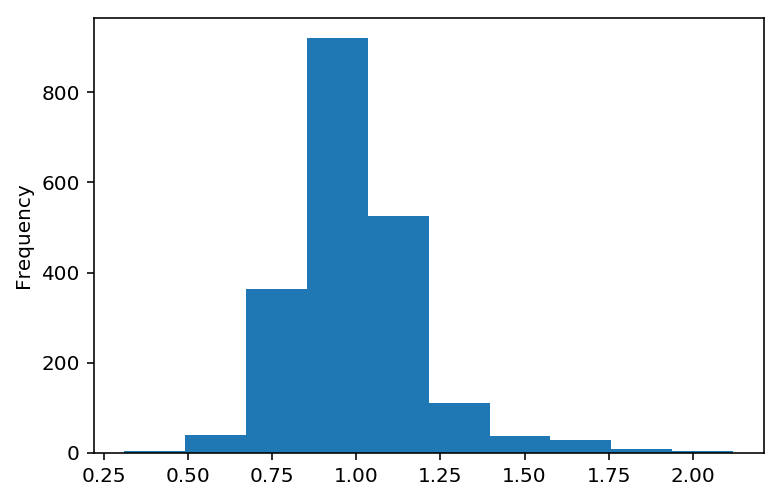

In [295]:
df_train['T4U'].plot(kind = 'hist')

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1029: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


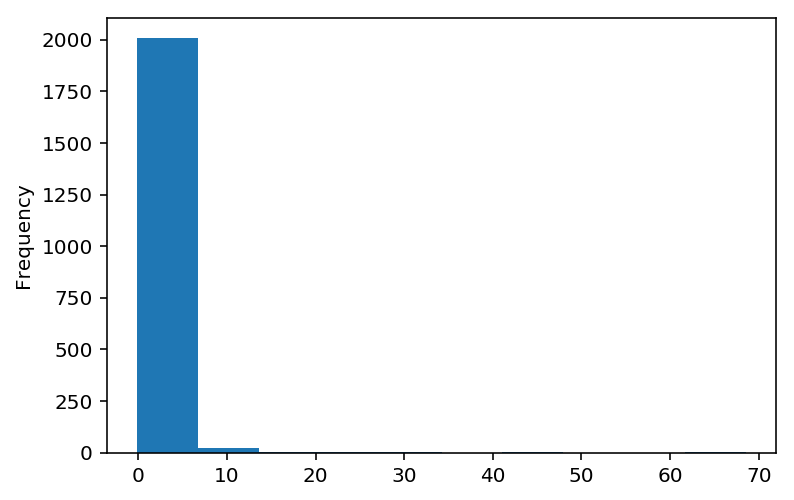

In [303]:
tmp = df_train.copy()
tmp['T4U'], _ = boxcox(df_train['T4U'])
tmp['T4U'].plot(kind = 'hist')

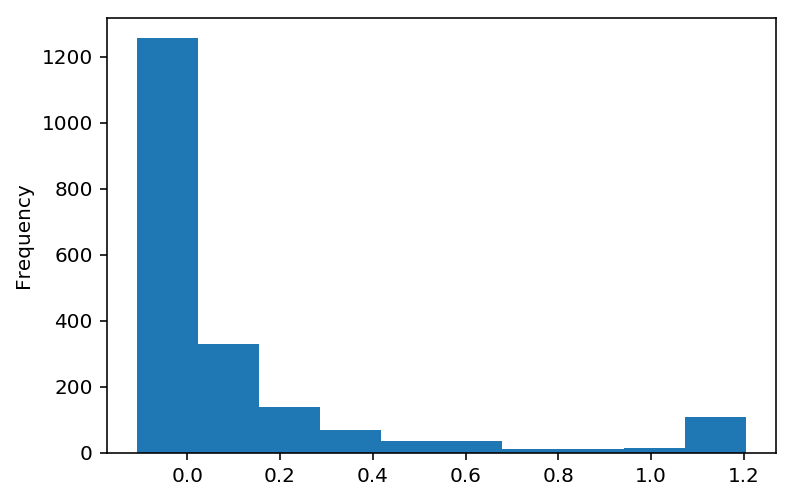

In [296]:
transformed2['T4U'].plot(kind = 'hist')

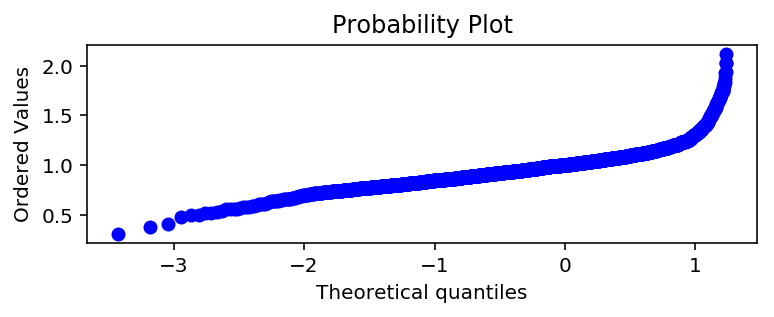

In [46]:
from scipy import stats
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = stats.loggamma.rvs(5, size=500) + 5
prob = stats.probplot(df_train.T4U, dist=stats.norm, plot=ax1)

# to sa oplati

### Filling missing values

Our dataset contains also missing values (NaN), that should be filled before using them in machine learning algorithm. Missing values of numerical, and also categorical attributes should be filled.

#### Fill numerical with median

Numerical attributes can be filled by median, stdev, etc. For this purposes, we have chosen *median*.

At first, we wanted to use *SimpleImputer* in combination with *FeatureUnion* and *FunctionTransformer*, to choose numerical and categorical attributes. There is a problem using that, because *FeatureUnion* and *FunctionTransformer* are creating *numpy* arrays from our DataFrame. There could be one more transformation to dataframe, but we decided to create our own, more simple solution.

In [47]:
class NumMedianFiller(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        self.median = df[self.column].median()
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy.loc[df_copy[self.column].isnull(), self.column] = self.median
        return df_copy

In [48]:
fill_ppl = Pipeline([
                ('fm_T4U', NumMedianFiller('T4U')),
                ('fm_TT4', NumMedianFiller('TT4')),
                ('fm_T3', NumMedianFiller('T3')),
                ('fm_TSH', NumMedianFiller('TSH')),
                ('fm_FTI', NumMedianFiller('FTI')),
                ('fm_capital_loss', NumMedianFiller('capital-loss')),
                ('fm_capital_gain', NumMedianFiller('capital-gain')),
                ('fm_fnlwgt', NumMedianFiller('fnlwgt')),
                ('fm_hours_per_week', NumMedianFiller('hours-per-week')),
                ('fm_education_num', NumMedianFiller('education-num'))
            ])

In [49]:
filling_median = fill_ppl.fit(transformed)
tran_filled_median = filling_median.transform(transformed)

#### Fill numerical with Linear Regression algorithm

In [50]:
class NumModelFiller(TransformerMixin):
    def __init__(self, column, model):
        self.column = column
        self.model = model

    def fit(self, df, y=None, **fit_params):
        # choose all numeric attributes and drop nan values
        num_only = df.select_dtypes(include=[np.number]).dropna().drop('index', axis=1)
        
        # create X and y training subsets
        X_train = num_only[num_only.columns.difference([self.column])]
        y_train = num_only[self.column]
        
        self.model.fit(X_train, y_train)
        return self

    def transform(self, df, **transform_params):
        pass
        # choose only those rows that have missing value in 'column' attribute
        empty_rows = df[df[self.column].isna()]
        
        # create X subset, that will predict
        X_test = empty_rows[empty_rows.columns.difference([self.column])]
        
        # predict new values
        y_pred = self.model.predict(X_pred)
        
        # fill missing values with predicted ones
        df.loc[empty_rows.index, self.column] = y_pred
        
        return df

In [509]:
tryhard = Pipeline([
        ('skuska', NumModelFiller('T4U', LinearRegression()))
    ])

In [510]:
modelicek = tryhard.fit(transformed)

#### Fill numerical using Pipeline

In [507]:
fill_model_ppl = Pipeline([
                ('flr_T4U', NumMedianFiller('T4U')),
                ('flr_TT4', NumMedianFiller('TT4')),
                ('flr_T3', NumMedianFiller('T3')),
                ('flr_TSH', NumMedianFiller('TSH')),
                ('flr_FTI', NumMedianFiller('FTI')),
                ('flr_capital_loss', NumMedianFiller('capital-loss')),
                ('flr_capital_gain', NumMedianFiller('capital-gain')),
                ('flr_fnlwgt', NumMedianFiller('fnlwgt')),
                ('flr_hours_per_week', NumMedianFiller('hours-per-week')),
                ('flr_education_num', NumMedianFiller('education-num'))
            ])

NameError: name 'NumMedianFiller' is not defined

In [170]:
filling_model = fill_model_ppl.fit(transformed)
tran_filled_model = filling_model.transform(transformed)

#### Fill categorical with most frequent values

Categorical attributes can be filled by *most frequent* value which we have chosen for this purpose.
The reason for preferring our own way of filling values to imputer is already mentioned above.

In [50]:
class CategoricalMostFrequentFiller(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, df, y=None, **fit_params):
        self.most_frequent = df[self.column].value_counts().index[0]
        return self
    
    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy.loc[df_copy[self.column].isnull(), self.column] = self.most_frequent
        return df_copy

In [51]:
fill_mf = Pipeline([
                ('fc_mf_1', CategoricalMostFrequentFiller('T4U measured')),
                ('fc_mf_2', CategoricalMostFrequentFiller('thyroid surgery')),
                ('fc_mf_3', CategoricalMostFrequentFiller('goitre')),
                ('fc_mf_4', CategoricalMostFrequentFiller('TSH measured')),
                ('fc_mf_5', CategoricalMostFrequentFiller('on antithyroid medication')),
                ('fc_mf_6', CategoricalMostFrequentFiller('pregnant'))
            ])

In [52]:
fill_categorical_mf = fill_mf.fit(transformed)
filled_by_mf = fill_categorical_mf.transform(transformed)

#### Fill categorical with Random Forest algorithm

Another approach is to fill missing values using classifier - *Random Forest* to predict the values to be filled.

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
class CategoricalModelFiller(TransformerMixin):
    def __init__(self, column, columns):
        self.column = column
        self.columns = columns
        self.columns.remove(column)
        self.classificator = RandomForestClassifier(n_estimators = 100, max_depth = 9, random_state = 8)

    def setNumber(self, x):
        if str(x) == 'True':
            return 1
        if str(x) == 'False':
            return 0
        return -1

    def fit(self, df, y=None, **fit_params):
        df_copy = df.copy()

        for col in self.columns:
            df_copy[col] = df_copy[col].apply(lambda x: self.setNumber(x))

        tmp = pd.get_dummies(df_copy['sex'])
        tmp_columns = [*self.columns, *tmp.columns.values]
        df_copy = pd.concat([df_copy, tmp], axis=1)

        x_train = df_copy[~df_copy[self.column].isnull()]
        y_train = x_train[self.column]
        x_train = x_train[x_train.columns.difference([self.column])]
        
        self.model = self.classificator.fit(x_train[tmp_columns],y_train.astype(str))
        return self        
    def transform(self, df, **transform_params):
        df_copy = df.copy()
        orig_columns = df.columns.values
        
        for col in self.columns:
            df_copy[col] = df_copy[col].apply(lambda x: self.setNumber(x))
            
        tmp = pd.get_dummies(df_copy['sex'])
        tmp_columns = [*self.columns, *tmp.columns.values]
        df_copy = pd.concat([df_copy, tmp], axis=1)
        df = df[~df[self.column].isnull()]
        
        to_fill = df_copy[df_copy[self.column].isnull()].drop(self.column, axis=1)
        to_fill[self.column] = self.model.predict(to_fill[tmp_columns]).astype('bool')
        return df.append(to_fill[orig_columns], sort=True).reindex(orig_columns, axis=1)

#### Fill categorical using Pipeline

In [60]:
columns = ['query hyperthyroid','T4U measured','FTI measured','lithium','query hypothyroid','on thyroxine','tumor','sick', 'thyroid surgery','I131 treatment','TT4 measured', 'goitre', 'TSH measured', 'hypopituitary', 'query on thyroxine','T3 measured','on antithyroid medication', 'pregnant']

fill_RF = Pipeline([
                ('ff_1', CategoricalModelFiller('T4U measured', columns)),
                ('ff_2', CategoricalModelFiller('thyroid surgery', columns)),
                ('ff_3', CategoricalModelFiller('goitre', columns)),
                ('ff_4', CategoricalModelFiller('TSH measured', columns)),
                ('ff_5', CategoricalModelFiller('on antithyroid medication', columns)),
                ('ff_6', CategoricalModelFiller('pregnant', columns))
            ])

In [61]:
fill_categorical_RF = fill_RF.fit(transformed)
filled_by_RF = fill_categorical_RF.transform(transformed)

### Values distribution comparison
Comparison of values distribution - before filling values, after filling by most frequent and filling using Random Forest

In [63]:
def grouped_barplot(df, attribute, groupby, title=None, size=(5, 4), rotation=0):
    """Draw barplot of attribute, grouped by another attribute."""
    plt.rcParams['figure.figsize'] = size
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    sns.barplot(attribute, 'percentage', hue=groupby, data=data)
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.rcParams['figure.figsize'] = (5, 4)

Let's take a look at how distribution of values for attribute *pregnant* gets affected by filling (152 missing values).

In [48]:
transformed['pregnant'].value_counts()

False    2057
True       28
Name: pregnant, dtype: int64

In [53]:
filled_by_mf['pregnant'].value_counts()

False    2209
True       28
Name: pregnant, dtype: int64

In [58]:
filled_by_RF['pregnant'].value_counts()

False    2209
True       28
Name: pregnant, dtype: int64

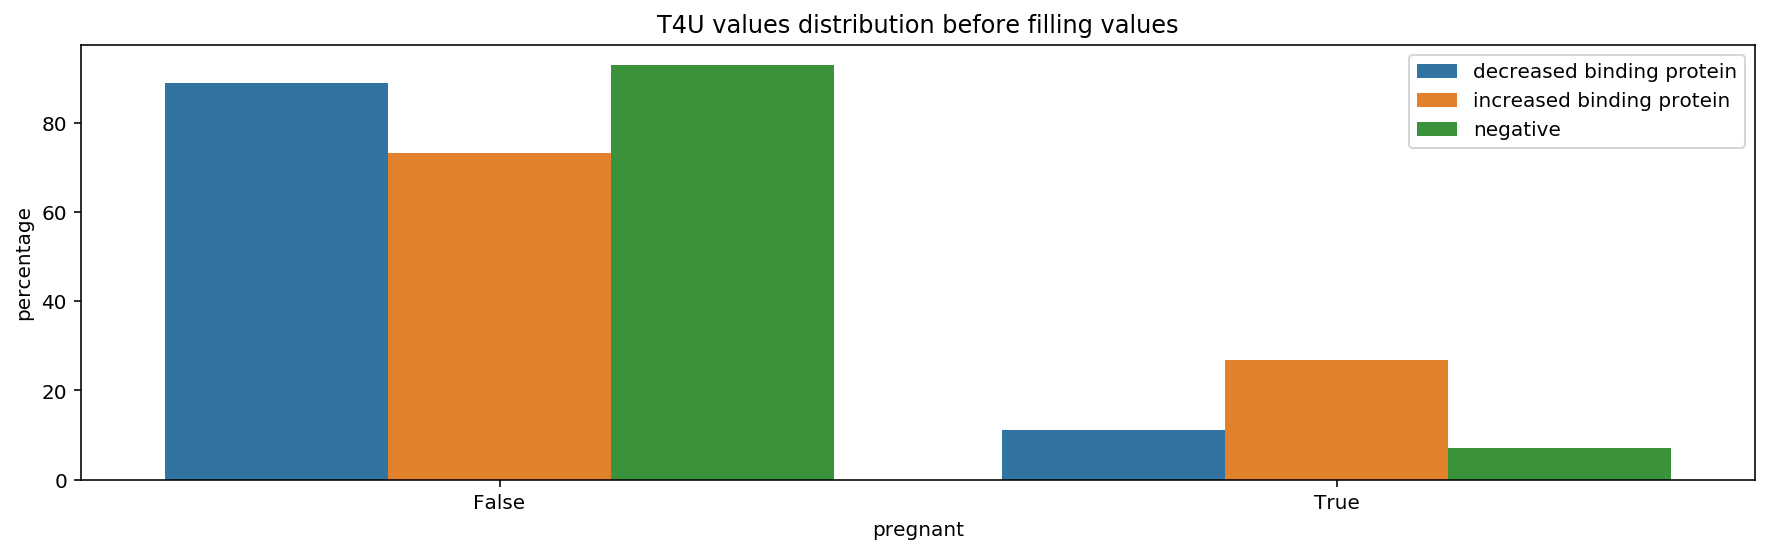

In [65]:
grouped_barplot(filled_by_RF, 'pregnant', 'class_status', 'T4U values distribution before filling values', size=(15,4))

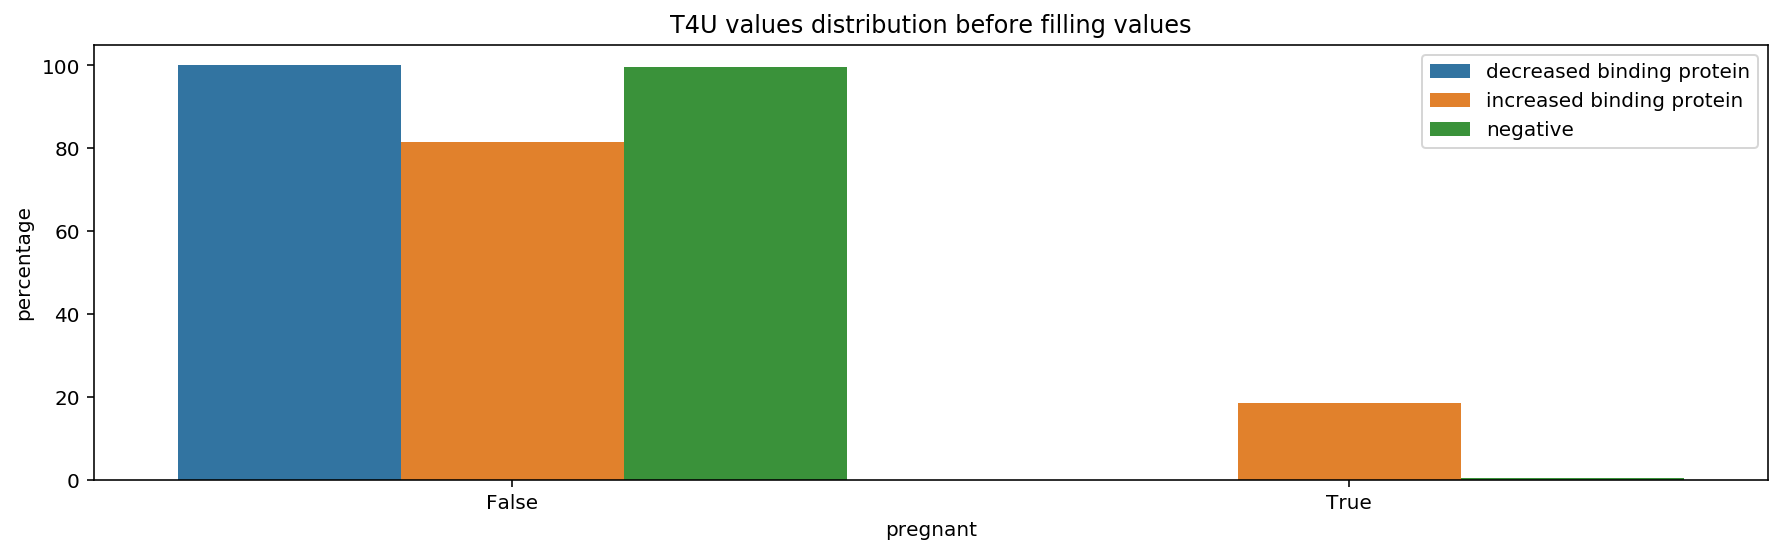

In [66]:
grouped_barplot(filled_by_mf, 'pregnant', 'class_status', 'T4U values distribution before filling values', size=(15,4))

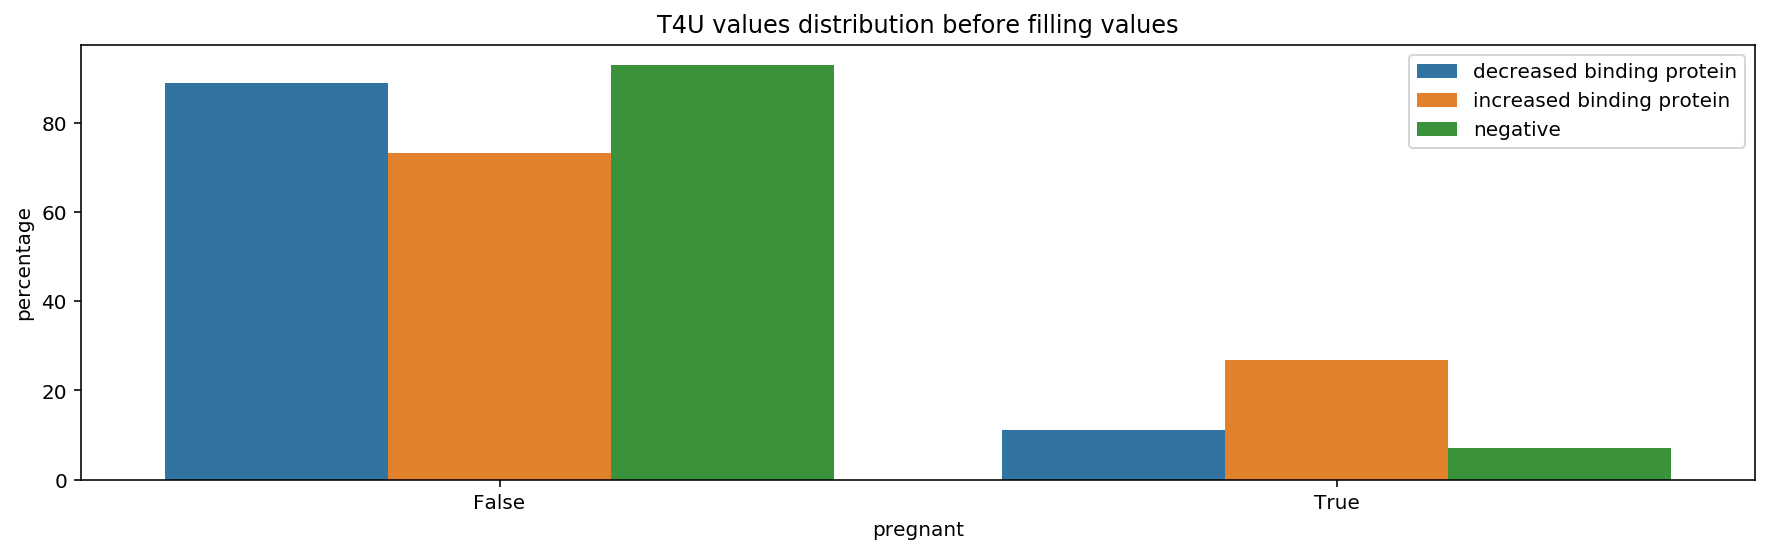

In [64]:
grouped_barplot(filled_by_RF, 'pregnant', 'class_status', 'T4U values distribution before filling values', size=(15,4))

In [68]:
transformed.isnull().sum()
transformed['origin']

0       united-states
1       united-states
2       united-states
3       united-states
4       united-states
5       united-states
6       united-states
7       united-states
8       united-states
9       united-states
10      united-states
11      united-states
12      united-states
13      united-states
14      united-states
15      united-states
16      united-states
17      united-states
18      united-states
19      united-states
20      united-states
21      united-states
22      united-states
23           thailand
24      united-states
25      united-states
26      united-states
27      united-states
28      united-states
29      united-states
            ...      
2207    united-states
2208             cuba
2209    united-states
2210    united-states
2211    united-states
2212    united-states
2213           mexico
2214    united-states
2215    united-states
2216    united-states
2217    united-states
2218    united-states
2219    united-states
2220    united-states
2221    un

# TO-DO

### Lukas
* doplnanie kategorickych cez RF alebo KNN
* urcit ktore atributy treba normalizovat
* zistit co je s normalizaciou
* porovnat doplnanie hodnot cez most frequent a modelom (kategoricke)

### Peter
* doplnanie numerickych cez linearnu regresiu
* porovnat doplnanie hodnot cez most frequent a modelom (kategoricke)
* urcit, kde treba vymazat outlierov
* okomentovat zmeny po vymazani outlierov

### IDK
* validovanie veku podla datumu
* viac pipelines? ako dat dokopy - pripadne ich skratit na styl imputera